In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
version = input()

In [3]:
dti_folder = f"/biodata/nyanovsky/datasets/dti/processed/{version}/"

In [4]:
import pickle
G = pickle.load(open(dti_folder+"dti_graph.pickle",'rb'))

In [5]:
def get_rel_subgraph(G: nx.Graph, rel: str) -> nx.Graph:
    rel_edges = [(u,v) for (u,v,r_dict) in G.edges.data() if r_dict["edge_type"]==rel]
    rel_subgraph = G.edge_subgraph(rel_edges).copy()
    return rel_subgraph

In [6]:
ChG_subgraph = get_rel_subgraph(G, "chg")
ChCh_subgraph = get_rel_subgraph(G, "chch")
GG_subgraph = get_rel_subgraph(G, "gg")

In [10]:
np.random.choice(G.nodes(), 2)

array(['C5359271', 'G7046'], dtype='<U10')

In [13]:
def sample_avg_shortest_path_length(G,n):
    nodes = G.nodes()
    lengths = []
    for _ in range(n):
        u,v = np.random.choice(nodes, 2)
        d = nx.shortest_path_length(G, u, v)
        lengths.append(d)
    return np.mean(lengths)


In [17]:
stats_df = pd.DataFrame(columns=["num nodes", "num edges", "% GC", "distancia media aproximada", "diam aproximado"], index=["full network", "Chemical-Chemical", "Chemical-Gene", "Gene-Gene"])

def get_stats(graph: nx.Graph):
    num_nodes, num_edges = graph.number_of_nodes(), graph.number_of_edges()

    gc = nx.subgraph(graph,max(nx.connected_components(graph), key=len))

    frac_gc = round(gc.number_of_nodes()/num_nodes,3) 

    avg_d = sample_avg_shortest_path_length(gc, 5000)
    approx_diam = nx.approximation.diameter(gc)
    return [num_nodes, num_edges, frac_gc, avg_d, approx_diam]

In [18]:
for i, g in enumerate([G, ChCh_subgraph, ChG_subgraph, GG_subgraph]):
    stats_df.iloc[i,:] = get_stats(g)

In [21]:
stats_df

,num nodes,num edges,% GC,distancia media aprox,diametro aprox
full network,11659,80221,0.999,3.8994,10
Chemical-Chemical,4469,20000,0.597,8.4232,29
Chemical-Gene,11659,38391,0.983,4.4058,13
Gene-Gene,3569,21830,0.395,6.1176,15


In [22]:
from collections import Counter
plt.style.use("ggplot")

In [24]:
import seaborn as sns

Text(0.5, 0, 'degree (log scale)')

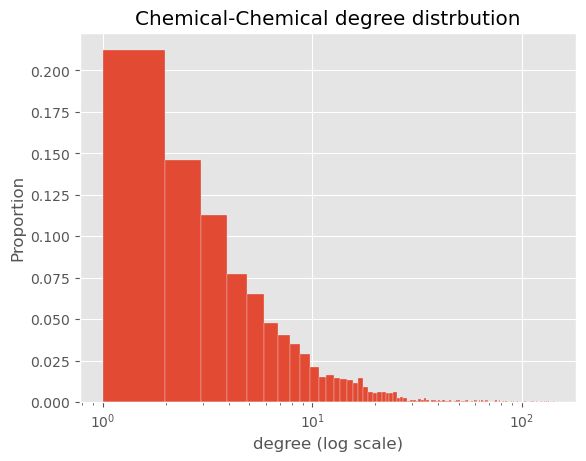

In [65]:
sns.histplot(ChCh_degs, bins=145, alpha=1, stat="proportion")
plt.xscale("log")
plt.title("Chemical-Chemical degree distrbution")
plt.xlabel("degree (log scale)")

Text(0.5, 0, 'degree')

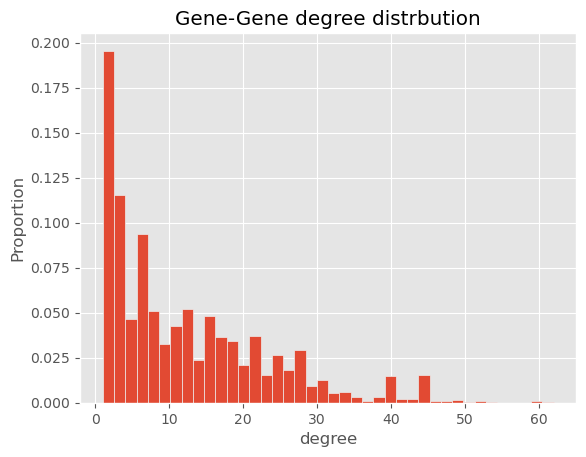

In [70]:
sns.histplot(GG_degs, bins=40, alpha=1, stat="proportion")
plt.title("Gene-Gene degree distrbution")
plt.xlabel("degree")

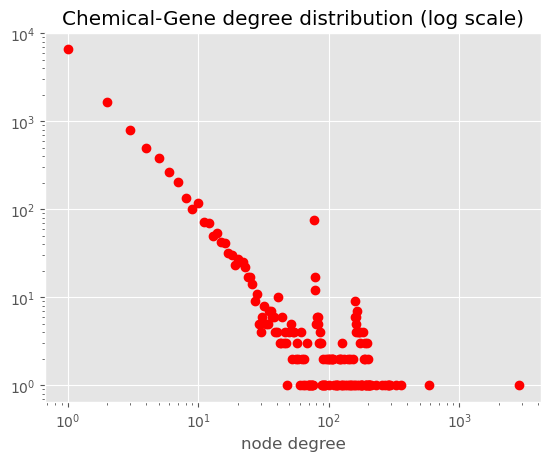

In [71]:
ChG_degs = [deg for node, deg in ChG_subgraph.degree()]
deg, counts = zip(*Counter(ChG_degs).items())
plt.loglog(deg, counts, "ro")
plt.title("Chemical-Gene degree distribution (log scale)")
plt.xlabel("node degree")
plt.show()

Veamos transitividad en la red, i.e cuantos triangulos se cierran de la forma Ch-Ch-G o G-G-Ch (Quiero ver si compuestos similares se pegan a las mismas proteinas, o si proteinas similares son targeteadas por el mismo compuesto)

In [15]:
def ChG_triangles(ChG_net):
    ChG_triangles = 0
    for u,v in ChG_net.edges():
        if u.startswith("C") and v.startswith("G"):
            chem, gene = u,v 
        else:
            chem, gene = v,u
        if chem in ChCh_subgraph.nodes():
            chem_neighs = ChCh_subgraph.neighbors(chem)
            for neigh in chem_neighs:
                if (neigh, gene) in ChG_net.edges() or (gene, neigh) in ChG_net.edges():
                    ChG_triangles += 1
        if gene in GG_subgraph.nodes():
            gene_neighs = GG_subgraph.neighbors(gene)
            for neigh in gene_neighs:
                if (neigh, chem) in ChG_net.edges() or (chem, neigh) in ChG_net.edges():
                    ChG_triangles += 1
    return ChG_triangles

In [16]:
ChG_connected_triplets = 0
for node in ChG_subgraph.nodes():
    if node in ChCh_subgraph.nodes() or node in GG_subgraph.nodes(): 
        # hay nodos de altisimo grado (como el Ca2+, o los citocromos) que no tienen conexiones con otras drogas/proteinas, 
        # no le veo sentido contar los posibles tripletes que puedan formar. 
        ChG_connected_triplets += len(set(ChG_subgraph.neighbors(node))) * (len(set(ChG_subgraph.neighbors(node)))-1)/2

        # esto funciona porque el subgrafo es bipartito, nunca se cuentan tripletes dos veces

In [17]:
valor_real = ChG_triangles(ChG_subgraph)/ChG_connected_triplets

In [18]:
ChG_subgraph.number_of_edges()

38391

In [19]:
import concurrent.futures

In [20]:
ChG_net = ChG_subgraph.copy()
def calc_triangle_coef(ChG_net):
    net = ChG_net.copy()
    nx.double_edge_swap(net,38000, 100000)
    return ChG_triangles(net)/ChG_connected_triplets

In [22]:
num_cores = 16
reps = 1000
with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = list(executor.map(calc_triangle_coef, [ChG_net] * reps))

frac_triangulos = results

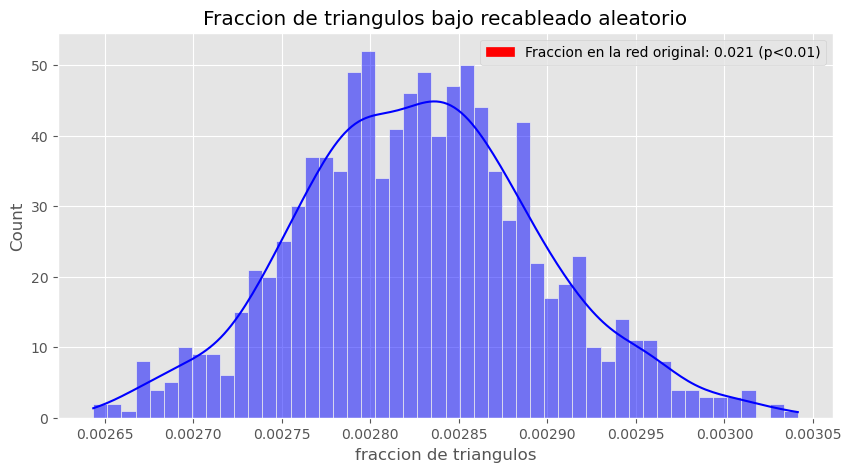

In [23]:
import seaborn as sns
from matplotlib.patches import Patch
custom_legend = [Patch(color='red', label=f'Fraccion en la red original: {valor_real:.3f} (p<0.01)')]

plt.figure(figsize=(10,5))
sns.histplot(frac_triangulos, bins=50, kde=True, color="blue",alpha=0.5)
plt.title("Fraccion de triangulos bajo recableado aleatorio")
plt.xlabel("fraccion de triangulos")
plt.legend(handles=custom_legend, loc="upper right")